Сеть является устойчивым одностадийным детектором, предоставляющим попиксельную локализацию для лиц разного масштаба.
Данная реализация взята с https://github.com/peteryuX/retinaface-tf2.git


![](https://translate.google.com/website?sl=en&tl=ru&prev=search&u=https://i2.wp.com/sefiks.com/wp-content/uploads/2021/04/retinaface-structure.png?ssl%3D1)

Архитектура сети состоит из 3 основных частей, каждая из которых имеет своё назначение:

a) Backbone – основная (базовая) сеть, служащая для извлечения признаков из поступающего на вход изображения. Данная часть сети является вариативной и в её основу могут входить классификационные нейросети, такие как ResNet, VGG, EfficientNet и другие;

b) Feature Pyramid Net (FPN) – свёрточная нейронная сеть, построенная в виде пирамиды, служащая для объединения достоинств карт признаков нижних и верхних уровней сети, первые имеют высокое разрешение, но низкую семантическую, обобщающую способность; вторые — наоборот;

с) Regression Subnet – подсеть, извлекающая из FPN информацию о координатах объектов на изображении, решая задачу регрессии.

In [1]:
#подключим необходимые библиотеки
import os
import zipfile
from dataclasses import dataclass

from absl import logging
import tqdm
import random
import tensorflow as tf
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

import yaml
import sys
import time

from tensorflow.keras.utils import plot_model

import copy

import numpy as np

%matplotlib inline

In [2]:
# Путь к базовому файлу конфигурации обучения (взят с гитхаба вместе с исходниками)
CFG_PATH = f'../input/configresnet/retinaface_res50.yaml' 

**Обучать будем на WIDER FACE. Датасет должен быть в формате tfrecord. Подготовленный датасет можно взять здесь:**
https://www.kaggle.com/b1qkoa/widerface

In [4]:
#Планировщик обучения
class PiecewiseConstantWarmUpDecay(
        tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule wiht warm up schedule.
    Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

    def __init__(self, boundaries, values, warmup_steps, min_lr,
                 name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda v=v: tf.constant(v)))

            # The default isn't needed here because our conditions are mutually
            # exclusive and exhaustive, but tf.case requires it.
            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

    def get_config(self):
        return {
                "boundaries": self.boundaries,
                "values": self.values,
                "warmup_steps": self.warmup_steps,
                "min_lr": self.min_lr,
                "name": self.name
        }

    
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    """Multi-steps warm up learning rate scheduler."""

    assert warmup_steps <= lr_steps[0], f"{warmup_steps} <= {lr_steps[0]}"
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)


In [5]:
#используемые функции потерь
def _smooth_l1_loss(y_true, y_pred):
    t = tf.abs(y_pred - y_true)
    return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)

def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
    """multi-box loss"""
    def multi_box_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]

        loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
        landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
        class_pred = tf.reshape(y_pred[2], [num_batch * num_prior, num_class])
        loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
        landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
        landm_valid = tf.reshape(y_true[..., 14], [num_batch * num_prior, 1])
        class_true = tf.reshape(y_true[..., 15], [num_batch * num_prior, 1])

        # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
        #                     landm_valid = 1 (w landm), 0 (w/o landm)
        mask_pos = tf.equal(class_true, 1)
        mask_neg = tf.equal(class_true, 0)
        mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

        # landm loss (smooth L1)
        mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
        loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
                                     tf.boolean_mask(landm_pred, mask_landm_b))
        loss_landm = tf.reduce_mean(loss_landm)

        # localization loss (smooth L1)
        mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
        loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
                                   tf.boolean_mask(loc_pred, mask_pos_b))
        loss_loc = tf.reduce_mean(loss_loc)

        # classification loss (crossentropy)
        # 1. compute max conf across batch for hard negative mining
        loss_class = tf.where(mask_neg,
                              1 - class_pred[:, 0][..., tf.newaxis], 0)

        # 2. hard negative mining
        loss_class = tf.reshape(loss_class, [num_batch, num_prior])
        loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
        loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
        mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
        num_pos_per_batch = tf.reduce_sum(
                tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
        num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
        num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
                                       tf.cast(num_prior, tf.float32) - 1)
        mask_hard_neg = tf.reshape(
            tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
            [num_batch * num_prior, 1])

        # 3. classification loss including positive and negative examples
        loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
        loss_class_mask_b = tf.broadcast_to(loss_class_mask,
                                            tf.shape(class_pred))
        filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
                                            loss_class_mask)
        filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
        filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
        loss_class = tf.keras.losses.sparse_categorical_crossentropy(
            y_true=filter_class_true, y_pred=filter_class_pred)
        loss_class = tf.reduce_mean(loss_class)

        return loss_loc, loss_landm, loss_class

    return multi_box_loss

In [6]:
#ключевые точки и рамки
def _encode_bbox(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return tf.concat([g_cxcy, g_wh], 1)  # [num_priors,4]


def _encode_landm(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 10].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded landm (tensor), Shape: [num_priors, 10]
    """

    # dist b/t match center and prior's center
    matched = tf.reshape(matched, [tf.shape(matched)[0], 5, 2])
    priors = tf.broadcast_to(
        tf.expand_dims(priors, 1), [tf.shape(matched)[0], 5, 4])
    g_cxcy = matched[:, :, :2] - priors[:, :, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, :, 2:])
    # g_cxcy /= priors[:, :, 2:]
    g_cxcy = tf.reshape(g_cxcy, [tf.shape(g_cxcy)[0], -1])
    # return target for smooth_l1_loss
    return g_cxcy

def _point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return tf.concat((boxes[:, :2] - boxes[:, 2:] / 2,
                      boxes[:, :2] + boxes[:, 2:] / 2), axis=1)


def _intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2]:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.maximum((max_xy - min_xy), tf.zeros_like(max_xy - min_xy))
    return inter[:, :, 0] * inter[:, :, 1]

def _jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

###############################################################################
#   Tensorflow Encoding                                                       #
###############################################################################
def encode_tf(labels, priors, match_thresh, ignore_thresh,
              variances=[0.1, 0.2]):
    """tensorflow encoding"""
    assert ignore_thresh <= match_thresh
    priors = tf.cast(priors, tf.float32)
    bbox = labels[:, :4]
    landm = labels[:, 4:-1]
    landm_valid = labels[:, -1]  # 1: with landm, 0: w/o landm.

    # jaccard index
    overlaps = _jaccard(bbox, _point_form(priors))

    # (Bipartite Matching)
    # [num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = tf.math.top_k(overlaps, k=1)
    best_prior_overlap = best_prior_overlap[:, 0]
    best_prior_idx = best_prior_idx[:, 0]

    # [num_priors] best ground truth for each prior
    overlaps_t = tf.transpose(overlaps)
    best_truth_overlap, best_truth_idx = tf.math.top_k(overlaps_t, k=1)
    best_truth_overlap = best_truth_overlap[:, 0]
    best_truth_idx = best_truth_idx[:, 0]

    # ensure best prior
    def _loop_body(i, bt_idx, bt_overlap):
        bp_mask = tf.one_hot(best_prior_idx[i], tf.shape(bt_idx)[0])
        bp_mask_int = tf.cast(bp_mask, tf.int32)
        new_bt_idx = bt_idx * (1 - bp_mask_int) + bp_mask_int * i
        bp_mask_float = tf.cast(bp_mask, tf.float32)
        new_bt_overlap = bt_overlap * (1 - bp_mask_float) + bp_mask_float * 2
        return tf.cond(best_prior_overlap[i] > match_thresh,
                       lambda: (i + 1, new_bt_idx, new_bt_overlap),
                       lambda: (i + 1, bt_idx, bt_overlap))
    _, best_truth_idx, best_truth_overlap = tf.while_loop(
        lambda i, bt_idx, bt_overlap: tf.less(i, tf.shape(best_prior_idx)[0]),
        _loop_body, [tf.constant(0), best_truth_idx, best_truth_overlap])

    matches_bbox = tf.gather(bbox, best_truth_idx)  # [num_priors, 4]
    matches_landm = tf.gather(landm, best_truth_idx)  # [num_priors, 10]
    matches_landm_v = tf.gather(landm_valid, best_truth_idx)  # [num_priors]

    loc_t = _encode_bbox(matches_bbox, priors, variances)
    landm_t = _encode_landm(matches_landm, priors, variances)
    landm_valid_t = tf.cast(matches_landm_v > 0, tf.float32)
    conf_t = tf.cast(best_truth_overlap > match_thresh, tf.float32)
    conf_t = tf.where(
        tf.logical_and(best_truth_overlap < match_thresh,
                       best_truth_overlap > ignore_thresh),
        tf.ones_like(conf_t) * -1, conf_t)    # 1: pos, 0: neg, -1: ignore

    return tf.concat([loc_t, landm_t, landm_valid_t[..., tf.newaxis],
                      conf_t[..., tf.newaxis]], axis=1)


def decode_tf(labels, priors, variances=[0.1, 0.2]):
    """tensorflow decoding"""
    bbox = _decode_bbox(labels[:, :4], priors, variances)
    landm = _decode_landm(labels[:, 4:14], priors, variances)
    landm_valid = labels[:, 14][:, tf.newaxis]
    conf = labels[:, 15][:, tf.newaxis]

    return tf.concat([bbox, landm, landm_valid, conf], axis=1)


def _decode_bbox(pre, priors, variances=[0.1, 0.2]):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

def _decode_landm(pre, priors, variances=[0.1, 0.2]):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = tf.concat(
        [priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:]], axis=1)
    return landms


###############################################################################
#   Tensorflow / Numpy Priors                                                 #
###############################################################################
import math
from itertools import product as product

def prior_box(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)

    return output

def prior_box_tf(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    image_sizes = tf.cast(tf.convert_to_tensor(image_sizes), tf.float32)
    feature_maps = tf.math.ceil(
        tf.reshape(image_sizes, [1, 2]) /
        tf.reshape(tf.cast(steps, tf.float32), [-1, 1]))

    anchors = []
    for k in range(len(min_sizes)):
        grid_x, grid_y = _meshgrid_tf(tf.range(feature_maps[k][1]),
                                      tf.range(feature_maps[k][0]))
        cx = (grid_x + 0.5) * steps[k] / image_sizes[1]
        cy = (grid_y + 0.5) * steps[k] / image_sizes[0]
        cxcy = tf.stack([cx, cy], axis=-1)
        cxcy = tf.reshape(cxcy, [-1, 2])
        cxcy = tf.repeat(cxcy, repeats=tf.shape(min_sizes[k])[0], axis=0)

        sx = min_sizes[k] / image_sizes[1]
        sy = min_sizes[k] / image_sizes[0]
        sxsy = tf.stack([sx, sy], 1)
        sxsy = tf.repeat(sxsy[tf.newaxis],
                         repeats=tf.shape(grid_x)[0] * tf.shape(grid_x)[1],
                         axis=0)
        sxsy = tf.reshape(sxsy, [-1, 2])

        anchors.append(tf.concat([cxcy, sxsy], 1))

    output = tf.concat(anchors, axis=0)

    if clip:
        output = tf.clip_by_value(output, 0, 1)

    return output


def _meshgrid_tf(x, y):
    """ workaround solution of the tf.meshgrid() issue:
        https://github.com/tensorflow/tensorflow/issues/34470"""
    grid_shape = [tf.shape(y)[0], tf.shape(x)[0]]
    grid_x = tf.broadcast_to(tf.reshape(x, [1, -1]), grid_shape)
    grid_y = tf.broadcast_to(tf.reshape(y, [-1, 1]), grid_shape)
    return grid_x, grid_y

In [7]:
#составные части модели
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU

import pickle

def _regularizer(weights_decay):
    """l2 regularizer"""
    return tf.keras.regularizers.l2(weights_decay)

def _kernel_init(scale=1.0, seed=None):
    """He normal initializer"""
    return tf.keras.initializers.he_normal()

class BatchNormalization(tf.keras.layers.BatchNormalization):
    """Make trainable=False freeze BN for real (the og version is sad).
       ref: https://github.com/zzh8829/yolov3-tf2
    """
    def __init__(self, axis=-1, momentum=0.9, epsilon=1e-5, center=True,
                 scale=True, name=None, **kwargs):
        super(BatchNormalization, self).__init__(
            axis=axis, momentum=momentum, epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs)

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)

        return super().call(x, training)
    

class ConvUnit(tf.keras.layers.Layer):
    """Conv + BN + Act"""
    def __init__(self, f, k, s, wd, act=None, name='ConvBN', **kwargs):
        super(ConvUnit, self).__init__(name=name, **kwargs)
        self.conv = Conv2D(filters=f, kernel_size=k, strides=s, padding='same',
                           kernel_initializer=_kernel_init(),
                           kernel_regularizer=_regularizer(wd),
                           use_bias=False, name='conv')
        self.bn = BatchNormalization(name='bn')

        if act is None:
            self.act_fn = tf.identity
        elif act == 'relu':
            self.act_fn = ReLU()
        elif act == 'lrelu':
            self.act_fn = LeakyReLU(0.1)
        else:
            raise NotImplementedError(
                'Activation function type {} is not recognized.'.format(act))

    def call(self, x):
        return self.act_fn(self.bn(self.conv(x)))

class FPN(tf.keras.layers.Layer):
    """Feature Pyramid Network"""
    def __init__(self, out_ch, wd, name='FPN', **kwargs):
        super(FPN, self).__init__(name=name, **kwargs)
        act = 'relu'
        if (out_ch <= 64):
            act = 'lrelu'

        self.output1 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.output2 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.output3 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.merge1 = ConvUnit(f=out_ch, k=3, s=1, wd=wd, act=act)
        self.merge2 = ConvUnit(f=out_ch, k=3, s=1, wd=wd, act=act)

    def call(self, x):
        output1 = self.output1(x[0])  # [80, 80, out_ch]
        output2 = self.output2(x[1])  # [40, 40, out_ch]
        output3 = self.output3(x[2])  # [20, 20, out_ch]

        up_h, up_w = tf.shape(output2)[1], tf.shape(output2)[2]
        up3 = tf.image.resize(output3, [up_h, up_w], method='nearest')
        output2 = output2 + up3
        output2 = self.merge2(output2)

        up_h, up_w = tf.shape(output1)[1], tf.shape(output1)[2]
        up2 = tf.image.resize(output2, [up_h, up_w], method='nearest')
        output1 = output1 + up2
        output1 = self.merge1(output1)

        return output1, output2, output3
    
class SSH(tf.keras.layers.Layer):
    """Single Stage Headless Layer"""
    def __init__(self, out_ch, wd, name='SSH', **kwargs):
        super(SSH, self).__init__(name=name, **kwargs)
        assert out_ch % 4 == 0
        act = 'relu'
        if (out_ch <= 64):
            act = 'lrelu'

        self.conv_3x3 = ConvUnit(f=out_ch // 2, k=3, s=1, wd=wd, act=None)

        self.conv_5x5_1 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=act)
        self.conv_5x5_2 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=None)

        self.conv_7x7_2 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=act)
        self.conv_7x7_3 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=None)

        self.relu = ReLU()
              
    
class BboxHead(tf.keras.layers.Layer):
    """Bbox Head Layer"""
    def __init__(self, num_anchor, wd, name='BboxHead', **kwargs):
        super(BboxHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 4, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 4])


class LandmarkHead(tf.keras.layers.Layer):
    """Landmark Head Layer"""
    def __init__(self, num_anchor, wd, name='LandmarkHead', **kwargs):
        super(LandmarkHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 10, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 10])
    
def Backbone(backbone_type='ResNet50', use_pretrain=True):
    """Backbone Model"""
    weights = None
    if use_pretrain:
        weights = 'imagenet'

    def backbone(x):
        if backbone_type == 'ResNet50':
            extractor = ResNet50(
                input_shape=x.shape[1:], include_top=False, weights=weights)
            pick_layer1 = 80  # [80, 80, 512]
            pick_layer2 = 142  # [40, 40, 1024]
            pick_layer3 = 174  # [20, 20, 2048]
            preprocess = tf.keras.applications.resnet.preprocess_input
        elif backbone_type == 'MobileNetV2':
            extractor = MobileNetV2(
                input_shape=x.shape[1:], include_top=False, weights=weights)
            pick_layer1 = 54  # [80, 80, 32]
            pick_layer2 = 116  # [40, 40, 96]
            pick_layer3 = 143  # [20, 20, 160]
            preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
        else:
            raise NotImplementedError(
                'Backbone type {} is not recognized.'.format(backbone_type))

        return Model(extractor.input,
                     (extractor.layers[pick_layer1].output,
                      extractor.layers[pick_layer2].output,
                      extractor.layers[pick_layer3].output),
                     name=backbone_type + '_extrator')(preprocess(x))

    return backbone

class ClassHead(tf.keras.layers.Layer):
    """Class Head Layer"""
    def __init__(self, num_anchor, wd, name='ClassHead', **kwargs):
        super(ClassHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 2, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 2])

def RetinaFaceModel(cfg, training=False, iou_th=0.4, score_th=0.02,
                    name='RetinaFaceModel'):
    """Retina Face Model"""
    input_size = cfg['input_size'] if training else None
    wd = cfg['weights_decay']
    out_ch = cfg['out_channel']
    num_anchor = len(cfg['min_sizes'][0])
    backbone_type = cfg['backbone_type']

    # define model
    x = inputs = Input([input_size, input_size, 3], name='input_image')

    x = Backbone(backbone_type=backbone_type)(x)

    fpn = FPN(out_ch=out_ch, wd=wd)(x)

    features = [SSH(out_ch=out_ch, wd=wd, name=f'SSH_{i}')(f)
                for i, f in enumerate(fpn)]

    bbox_regressions = tf.concat(
        [BboxHead(num_anchor, wd=wd, name=f'BboxHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)
    landm_regressions = tf.concat(
        [LandmarkHead(num_anchor, wd=wd, name=f'LandmarkHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)
    classifications = tf.concat(
        [ClassHead(num_anchor, wd=wd, name=f'ClassHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

    classifications = tf.keras.layers.Softmax(axis=-1)(classifications)

    if training:
        out = (bbox_regressions, landm_regressions, classifications)
    else:
        # only for batch size 1
        preds = tf.concat(  # [bboxes, landms, landms_valid, conf]
            [bbox_regressions[0], landm_regressions[0],
             tf.ones_like(classifications[0, :, 0][..., tf.newaxis]),
             classifications[0, :, 1][..., tf.newaxis]], 1)
        

        priors = prior_box_tf((tf.shape(inputs)[1], tf.shape(inputs)[2]),
                                cfg['min_sizes'],  cfg['steps'], cfg['clip'])

        decode_preds = decode_tf(preds, priors, cfg['variances'])

        selected_indices = tf.image.non_max_suppression(
            boxes=decode_preds[:, :4],
            scores=decode_preds[:, -1],
            max_output_size=tf.shape(decode_preds)[0],
            iou_threshold=iou_th,
            score_threshold=score_th)

        out = tf.gather(decode_preds, selected_indices)

    return Model(inputs, out, name=name)

In [8]:
#функции для работы с датасетом

def _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                    using_encoding, priors, match_thresh, ignore_thresh,
                    variances):
    def parse_tfrecord(tfrecord):
        features = {
            'image/img_name': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark0/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark0/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark1/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark1/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark2/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark2/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark3/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark3/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark4/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark4/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark/valid': tf.io.VarLenFeature(tf.float32)}
        if using_bin:
            features['image/encoded'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            img = tf.image.decode_jpeg(x['image/encoded'], channels=3)
        else:
            features['image/img_path'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            image_encoded = tf.io.read_file(x['image/img_path'])
            img = tf.image.decode_jpeg(image_encoded, channels=3)

        labels = tf.stack(
            [tf.sparse.to_dense(x['image/object/bbox/xmin']),
             tf.sparse.to_dense(x['image/object/bbox/ymin']),
             tf.sparse.to_dense(x['image/object/bbox/xmax']),
             tf.sparse.to_dense(x['image/object/bbox/ymax']),
             tf.sparse.to_dense(x['image/object/landmark0/x']),
             tf.sparse.to_dense(x['image/object/landmark0/y']),
             tf.sparse.to_dense(x['image/object/landmark1/x']),
             tf.sparse.to_dense(x['image/object/landmark1/y']),
             tf.sparse.to_dense(x['image/object/landmark2/x']),
             tf.sparse.to_dense(x['image/object/landmark2/y']),
             tf.sparse.to_dense(x['image/object/landmark3/x']),
             tf.sparse.to_dense(x['image/object/landmark3/y']),
             tf.sparse.to_dense(x['image/object/landmark4/x']),
             tf.sparse.to_dense(x['image/object/landmark4/y']),
             tf.sparse.to_dense(x['image/object/landmark/valid'])], axis=1)

        img, labels = _transform_data(
            img_dim, using_flip, using_distort, using_encoding, priors,
            match_thresh, ignore_thresh, variances)(img, labels)

        return img, labels
    return parse_tfrecord


def _transform_data(img_dim, using_flip, using_distort, using_encoding, priors,
                    match_thresh, ignore_thresh, variances):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)

        # randomly crop
        img, labels = _crop(img, labels)

        # padding to square
        img = _pad_to_square(img)

        # resize
        img, labels = _resize(img, labels, img_dim)

        # randomly left-right flip
        if using_flip:
            img, labels = _flip(img, labels)

        # distort
        if using_distort:
            img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors,
                               match_thresh=match_thresh,
                               ignore_thresh=ignore_thresh,
                               variances=variances)

        return img, labels
    return transform_data


def load_tfrecord_dataset(tfrecord_name, batch_size, img_dim,
                          using_bin=True, using_flip=True, using_distort=True,
                          using_encoding=True, priors=None, match_thresh=0.45,
                          ignore_thresh=0.3, variances=[0.1, 0.2],
                          shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    if not using_encoding:
        assert batch_size == 1  # dynamic data len when using_encoding
    else:
        assert priors is not None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                        using_encoding, priors, match_thresh, ignore_thresh,
                        variances),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


###############################################################################
#   Data Augmentation                                                         #
###############################################################################
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                1 - labels[:, 6],  labels[:, 7],
                                1 - labels[:, 4],  labels[:, 5],
                                1 - labels[:, 8],  labels[:, 9],
                                1 - labels[:, 12], labels[:, 13],
                                1 - labels[:, 10], labels[:, 11],
                                labels[:, 14]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],
                          default=lambda: (img, labels))

    return img, labels


def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        """
        return iof of a and b, numpy version for data augenmentation
        """
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4] - w_offset,  labels_t[:, 5] - h_offset,
             labels_t[:, 6] - w_offset,  labels_t[:, 7] - h_offset,
             labels_t[:, 8] - w_offset,  labels_t[:, 9] - h_offset,
             labels_t[:, 10] - w_offset, labels_t[:, 11] - h_offset,
             labels_t[:, 12] - w_offset, labels_t[:, 13] - h_offset,
             labels_t[:, 14]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 15])])

    return img, labels


def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img


def _resize(img, labels, img_dim):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f,
                     labels[:, 4] / w_f,  labels[:, 5] / h_f,
                     labels[:, 6] / w_f,  labels[:, 7] / h_f,
                     labels[:, 8] / w_f,  labels[:, 9] / h_f,
                     labels[:, 10] / w_f, labels[:, 11] / h_f,
                     labels[:, 12] / w_f, labels[:, 13] / h_f], axis=1)
    locs = tf.clip_by_value(locs, 0, 1)
    labels = tf.concat([locs, labels[:, 14][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            return tf.image.resize(
                img, [img_dim, img_dim], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels


def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

In [9]:
#вспомогательные функции

def load_yaml(load_path): 
    """load yaml file"""
    with open(load_path, 'r') as f:
        loaded = yaml.load(f, Loader=yaml.Loader)

    return loaded


def set_memory_growth(): #
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices(
                    'GPU')
                logging.info(
                    "Detect {} Physical GPUs, {} Logical GPUs.".format(
                        len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            logging.info(e)


def load_dataset(cfg, priors, shuffle=True, buffer_size=10240): #
    """load dataset"""
    logging.info("load dataset from {}".format(cfg['dataset_path']))
    dataset = load_tfrecord_dataset(
        tfrecord_name=cfg['dataset_path'],
        batch_size=cfg['batch_size'],
        img_dim=cfg['input_size'],
        using_bin=cfg['using_bin'],
        using_flip=cfg['using_flip'],
        using_distort=cfg['using_distort'],
        using_encoding=True,
        priors=priors,
        match_thresh=cfg['match_thresh'],
        ignore_thresh=cfg['ignore_thresh'],
        variances=cfg['variances'],
        shuffle=shuffle,
        buffer_size=buffer_size)
    return dataset


class ProgressBar(object): #
    """A progress bar which can print the progress modified from
       https://github.com/hellock/cvbase/blob/master/cvbase/progress.py"""
    def __init__(self, task_num=0, completed=0, bar_width=25):
        self.task_num = task_num
        max_bar_width = self._get_max_bar_width()
        self.bar_width = (bar_width
                          if bar_width <= max_bar_width else max_bar_width)
        self.completed = completed
        self.first_step = completed
        self.warm_up = False

    def _get_max_bar_width(self):
        if sys.version_info > (3, 3):
            from shutil import get_terminal_size
        else:
            from backports.shutil_get_terminal_size import get_terminal_size
        terminal_width, _ = get_terminal_size()
        max_bar_width = min(int(terminal_width * 0.6), terminal_width - 50)
        if max_bar_width < 10:
            logging.info('terminal width is too small ({}), please consider '
                         'widen the terminal for better progressbar '
                         'visualization'.format(terminal_width))
            max_bar_width = 10
        return max_bar_width

    def reset(self):
        """reset"""
        self.completed = 0
        self.fps = 0

    def update(self, inf_str=''):
        """update"""
        self.completed += 1

        if not self.warm_up:
            self.start_time = time.time() - 1e-1
            self.warm_up = True

        if self.completed > self.task_num:
            self.completed = self.completed % self.task_num
            self.start_time = time.time() - 1 / self.fps
            self.first_step = self.completed - 1
            sys.stdout.write('\n')

        elapsed = time.time() - self.start_time
        self.fps = (self.completed - self.first_step) / elapsed
        percentage = self.completed / float(self.task_num)
        mark_width = int(self.bar_width * percentage)
        bar_chars = '>' * mark_width + ' ' * (self.bar_width - mark_width)
        stdout_str = '\rTraining [{}] {}/{}, {}  {:.1f} step/sec'
        sys.stdout.write(stdout_str.format(
            bar_chars, self.completed, self.task_num, inf_str, self.fps))

        sys.stdout.flush()


###############################################################################
#   Testing                                                                   #
###############################################################################
def pad_input_image(img, max_steps): 
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params


def recover_pad_output(outputs, pad_params): 
    """recover the padded output effect"""
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    recover_xy = np.reshape(outputs[:, :14], [-1, 7, 2]) * \
        [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[:, :14] = np.reshape(recover_xy, [-1, 14])

    return outputs


###############################################################################
#   Visulization                                                              #
###############################################################################
def draw_bbox_landm(img, ann, img_height, img_width): 
    """draw bboxes and landmarks"""
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                     int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # confidence
    text = "{:.4f}".format(ann[15])
    cv2.putText(img, text, (int(ann[0] * img_width), int(ann[1] * img_height)),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # landmark
    if ann[14] > 0:
        cv2.circle(img, (int(ann[4] * img_width),
                         int(ann[5] * img_height)), 1, (255, 255, 0), 2) # right eye
        cv2.circle(img, (int(ann[6] * img_width),
                         int(ann[7] * img_height)), 1, (0, 255, 255), 2) # left eye
        cv2.circle(img, (int(ann[8] * img_width),
                         int(ann[9] * img_height)), 1, (255, 0, 0), 2) # nose
        cv2.circle(img, (int(ann[10] * img_width),
                         int(ann[11] * img_height)), 1, (0, 100, 255), 2) # mr
        cv2.circle(img, (int(ann[12] * img_width),
                         int(ann[13] * img_height)), 1, (255, 0, 100), 2) # ml




In [10]:
# Структура содели
class RetinaFace:
    
    # Загрузка чекпойнта
    def __load_checkpoint(self):

        checkpoint_dir = './checkpoints/' + self.cfg['sub_name']
        checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                         optimizer=self.optimizer,
                                         model=self.model)
        manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                             directory=checkpoint_dir,
                                             max_to_keep=3)
        '''
        if manager.latest_checkpoint:
            checkpoint.restore(manager.latest_checkpoint)
            print('[*] load ckpt from {} at step {} for training.'.format(
                manager.latest_checkpoint, checkpoint.step.numpy()))
        else:
            print("[*] training from scratch.")
            '''
            
        return manager, checkpoint
    

        
    
    def __init__(self, cfg, **kwargs):
        # init
        SCORE_TH = 0.5
        IOU_TH = 0.4
        
        self.manager = None
        self.checkpoint = None
        
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        os.environ['CUDA_VISIBLE_DEVICES'] = '0'

        logger = tf.get_logger()
        logger.disabled = True
        logger.setLevel(logging.FATAL)
        set_memory_growth()
        
        # Конфиг
        self.cfg = load_yaml(cfg)
        
        # Наша модель
        self.model = RetinaFaceModel(self.cfg, training=True)
        self.predict_model = RetinaFaceModel(self.cfg, training=False, iou_th=IOU_TH,
                            score_th=SCORE_TH)
        
        self.priors = prior_box((self.cfg['input_size'], self.cfg['input_size']),
                           self.cfg['min_sizes'],  self.cfg['steps'], self.cfg['clip'])
        
        # Датасет
        self.train_dataset = load_dataset(self.cfg, self.priors, shuffle=True)
        
        # Шаг
        self.steps_per_epoch = self.cfg['dataset_len'] // self.cfg['batch_size']
        
        # LR
        self.learning_rate = MultiStepWarmUpLR(
            initial_learning_rate=self.cfg['init_lr'],
            lr_steps=[e * self.steps_per_epoch for e in self.cfg['lr_decay_epoch']],
            lr_rate=self.cfg['lr_rate'],
            warmup_steps=self.cfg['warmup_epoch'] * self.steps_per_epoch,
            min_lr=self.cfg['min_lr'])
        
        # Otpimizer (SGD)
        self.optimizer = tf.keras.optimizers.SGD(
            learning_rate=self.learning_rate, momentum=0.9, nesterov=True)
        
        # Loss
        self.multi_box_loss = MultiBoxLoss()
        
        # Fit Status
        self.is_fitted = False
  
    
    def get_model(self):
        return self.model
    
    # Обучаем модель
    def fit(self):
        # Чекпойнты
        self.manager, self.checkpoint = self.__load_checkpoint()    
        
        # Шаг обучения
        @tf.function
        def train_step(inputs, labels):
            with tf.GradientTape() as tape:
                predictions = self.model(inputs, training=True)

                losses = {}
                losses['reg'] = tf.reduce_sum(self.model.losses)
                losses['loc'], losses['landm'], losses['class'] = \
                    self.multi_box_loss(labels, predictions)
                total_loss = tf.add_n([l for l in losses.values()])

            grads = tape.gradient(total_loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            return total_loss, losses

        # Цикл обучения модели
        summary_writer = tf.summary.create_file_writer('./logs/' + self.cfg['sub_name'])
        remain_steps = max(
            self.steps_per_epoch * self.cfg['epoch'] - self.checkpoint.step.numpy(), 0)
        prog_bar = ProgressBar(self.steps_per_epoch,
                               self.checkpoint.step.numpy() % self.steps_per_epoch)
        
        if remain_steps > 0:
            for inputs, labels in self.train_dataset.take(remain_steps):
                self.checkpoint.step.assign_add(1)
                steps = self.checkpoint.step.numpy()

                total_loss, losses = train_step(inputs, labels)

                prog_bar.update("epoch={}/{}, loss={:.4f}, lr={:.1e}".format(
                    ((steps - 1) // self.steps_per_epoch) + 1, self.cfg['epoch'],
                    total_loss.numpy(), self.optimizer.lr(steps).numpy()))

                if steps % 10 == 0:
                    with summary_writer.as_default():
                        tf.summary.scalar(
                            'loss/total_loss', total_loss, step=steps)
                        for k, l in losses.items():
                            tf.summary.scalar('loss/{}'.format(k), l, step=steps)
                        tf.summary.scalar(
                            'learning_rate', self.optimizer.lr(steps), step=steps)

                if steps % self.cfg['save_steps'] == 0:
                    self.manager.save()
                    print("\n[*] save ckpt file at {}".format(
                        self.manager.latest_checkpoint))

            self.manager.save()
            print("\n[*] training done! save ckpt file at {}".format(
                self.manager.latest_checkpoint))
        
        self.is_fitted = True
    
    
    '''Принимает список изображений'''
    def predict(self, X):
        down_scale_factor = 1
        
        assert self.is_fitted == True, "Сначала обучите модель методом fit"
        assert isinstance(X, list), "Передайте список изображений numpy"
        
        # Inference model checkpoint
        checkpoint_dir = './checkpoints/' + self.cfg['sub_name']
        checkpoint = tf.train.Checkpoint(model=self.predict_model)
        
        if tf.train.latest_checkpoint(checkpoint_dir):
            checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
            print("[*] load ckpt from {} to inference model.".format(
                tf.train.latest_checkpoint(checkpoint_dir)))
        else:
            print("[*] Cannot find ckpt from {}.".format(checkpoint_dir))
            exit()
        
        predicts = {}
        
        predicts['outputs'] = []
        predicts['image_params'] = []
        
        for _img in X:
            
            img_raw = cv2.imread(_img)
            img_height_raw, img_width_raw, _ = img_raw.shape
            img = np.float32(img_raw.copy())

            if down_scale_factor < 1.0:
                img = cv2.resize(img, (0, 0), fx=down_scale_factor,
                                 fy=down_scale_factor,
                                 interpolation=cv2.INTER_LINEAR)
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # pad input image to avoid unmatched shape problem
            img, pad_params = pad_input_image(img, max_steps=max(self.cfg['steps']))

            # run model
            outputs = self.predict_model(img[np.newaxis, ...]).numpy()

            # recover padding effect
            outputs = recover_pad_output(outputs, pad_params)
            
            predicts['outputs'].append(outputs)
            predicts['image_params'].append((img_width_raw, img_height_raw))
        
        
        return predicts

In [11]:
# Зададим настройки обучения модели
BATCH_SIZE = 12 
EPOCHS = 10

## Настройки конфигов обучения
MODELS_CONFIG = {
    'ResNet50': {
        'cfg_path': f'../input/configresnet/retinaface_res50.yaml',
        'dataset_path': f'../input/widerface/widerface_train_bin.tfrecord',
        'batch_size': BATCH_SIZE,
        'testing_dataset_path': f'../input/widerface/val',
        'epoch': EPOCHS
    }
}

# Выберем backbone для RetinaFace
backbone_model = 'ResNet50'

dataset_path = MODELS_CONFIG[backbone_model]['dataset_path']
cfg_path = MODELS_CONFIG[backbone_model]['cfg_path']
batch_size = MODELS_CONFIG[backbone_model]['batch_size'] 
testing_dataset_path = MODELS_CONFIG[backbone_model]['testing_dataset_path']
epoch = MODELS_CONFIG[backbone_model]['epoch']

custom_config_path = f'./retinaface_res50.yaml'

In [12]:
# Внесем в конфиг локальные пути
import re

print('Вносим изменения в конфигурационный файл...')

with open('../input/configresnet/retinaface_res50.yaml') as f:
    s = f.read()
with open(custom_config_path, 'w') as f:

    # Batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Epochs
    epoch_re = re.compile(r"^epoch: [0-9]+", re.MULTILINE)
    s = re.sub(epoch_re,
               'epoch: {}'.format(epoch), s)
    
    # Dataset path
    s = re.sub('dataset_path: \'.\/data\/widerface_train_bin.tfrecord\'', f"dataset_path: '{dataset_path}'", s)
    
    # Val path
    s = re.sub('testing_dataset_path: \'.\/data\/widerface\/val\'', f"testing_dataset_path: '{testing_dataset_path}'", s)
            
    f.write(s)
    
print(f'Создан новый конфигурационный файл {custom_config_path}')

In [13]:
!cat {custom_config_path}

In [14]:
model = RetinaFace(custom_config_path)

In [15]:
# Обучим нашу модель или загрузим последний чекпойнт
model.fit()

Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=1/20, loss=1.9563, lr=2.8e-03  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>    ] 927/1073, epoch=2/20, loss=1.7385, lr=4.4e-03  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-1
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=2/20, loss=1.6306, lr=4.6e-03  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=3/20, loss=1.7246, lr=6.4e-03  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>       ] 781/1073, epoch=4/20, loss=1.5628, lr=7.7e-03  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-2
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=4/20, loss=1.3224, lr=8.2e-03  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=5/20, loss=1.5551, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>           ] 635/1073, epoch=6/20, loss=1.2184, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-3
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=6/20, loss=1.0650, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=7/20, loss=0.9035, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>              ] 489/1073, epoch=8/20, loss=0.8075, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-4
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=8/20, loss=1.1854, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=9/20, loss=0.7002, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>                  ] 343/1073, epoch=10/20, loss=0.6368, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-5
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=10/20, loss=0.8903, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=11/20, loss=0.6047, lr=1.0e-02  1.9 step/sec
Training [>>>>                     ] 197/1073, epoch=12/20, loss=0.4783, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-6
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=12/20, loss=0.5017, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=13/20, loss=0.6822, lr=1.0e-02  1.9 step/sec
Training [>                        ] 51/1073, epoch=14/20, loss=0.6164, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-7
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=14/20, loss=0.4165, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>   ] 978/1073, epoch=15/20, loss=0.3397, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-8
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=15/20, loss=0.5218, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=16/20, loss=0.4753, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>      ] 832/1073, epoch=17/20, loss=0.6528, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-9
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=17/20, loss=0.8137, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=18/20, loss=0.7227, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>          ] 686/1073, epoch=19/20, loss=0.6538, lr=1.0e-02  1.9 step/sec
[*] save ckpt file at ./checkpoints/retinaface_res50/ckpt-10
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=19/20, loss=0.5854, lr=1.0e-02  1.9 step/sec
Training [>>>>>>>>>>>>>>>>>>>>>>>>>] 1073/1073, epoch=20/20, loss=0.4825, lr=1.0e-02  1.9 step/sec
[*] training done! save ckpt file at ./checkpoints/retinaface_res50/ckpt-11


In [27]:
# Посмотрим на выходные данные
!ls -la './checkpoints/retinaface_res50/'

In [29]:
from IPython.display import FileLink
FileLink(r'./checkpoints/retinaface_res50/ckpt-6.index')

In [18]:
# Протестируем нашу модель на валидационной выборке
test_images = []

for path, subdirs, files in os.walk('../input/widerface/val'):
    for name in files:
        if name.endswith('.jpg'):
            test_images.append(os.path.join(path, name))




In [28]:

y_pred = model.predict(test_images[:101])

In [ ]:
#y_pred

In [20]:
# Функция рисования рамки и ключевых точек
def draw_bbox_and_landmarks(raw_image_list, predictions):
    
    preds_imgs = []
    
    for idx, pred in enumerate(predictions):
        img_raw = cv2.imread(raw_image_list[idx])
        img_height_raw, img_width_raw, _ = img_raw.shape
               
        for prior_index in range(len(pred)):
            draw_bbox_landm(img_raw, pred[prior_index], img_height_raw,
                            img_width_raw)
            
        preds_imgs.append(img_raw)
        
    return preds_imgs


def decode_predictions(image_params, y_pred_outputs):
    
    face_dict = {}

    for pred_index in range(len(y_pred_outputs)):
        img_width, img_height = image_params[0], image_params[1]
        ann = y_pred_outputs[pred_index]

        # bbox
        x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)

        # confidence
        conf = "{:.4f}".format(ann[15])

        # landmark
        if ann[14] > 0:
            right_eye = (int(ann[4] * img_width), int(ann[5] * img_height))
            left_eye = (int(ann[6] * img_width), int(ann[7] * img_height))
            nose = (int(ann[8] * img_width), int(ann[9] * img_height))
            mouth_right = (int(ann[10] * img_width), int(ann[11] * img_height))
            mouth_left = (int(ann[12] * img_width),int(ann[13] * img_height))           

        current_face = {'bbox': [x1, y1, x2, y2], 'score':conf, 'right_eye': right_eye, \
                        'left_eye': left_eye, 'nose': nose, 'mouth_right': mouth_right, \
                        'mouth_left': mouth_left}

        face_dict.setdefault(f'face_{pred_index}', []).append(current_face)

    return face_dict



In [21]:
# Нарисуем баундбоксы
boxed_img = draw_bbox_and_landmarks(test_images, y_pred['outputs'])
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(boxed_img[99], cv2.COLOR_BGR2RGB))

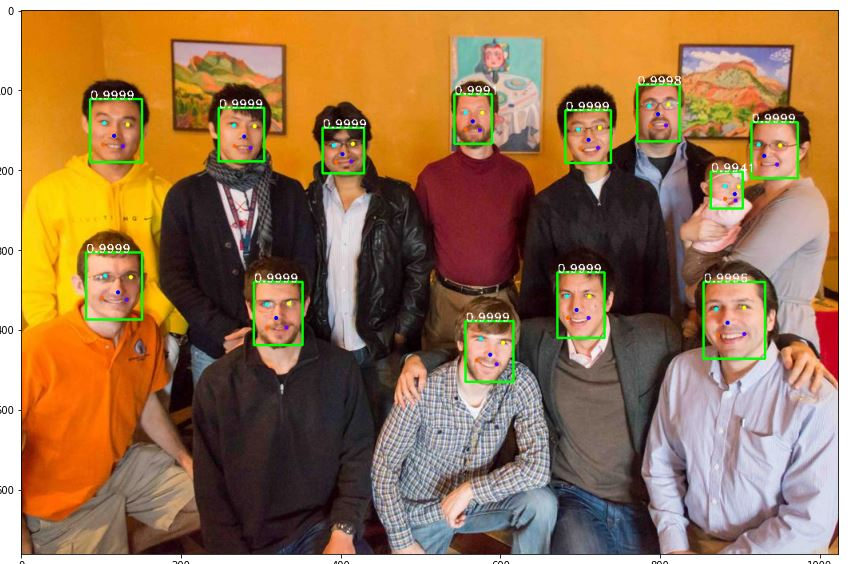

In [2]:
import os
from IPython.display import Image
Image(filename="./retinatest.JPG")

In [30]:
model.get_model().summary()

In [36]:
model.get_model().save('my_retina1')

In [42]:
!ls -la './my_retina1/variables'


In [44]:
FileLink(r'./my_retina1/variables/variables.data-00000-of-00001')